# 1. Introduction


**Question:** Given the data collected by HR, can you predict whether the employee will leave?

**Data:** We use the dataset available on Kaggle: 
https://www.kaggle.com/datasets/pankeshpatel/hrcommasep?select=HR_comma_sep.csv

The columns of the dataset are:


*   'satisfaction_level': on a scale 0 to 1
*   'last_evaluation': on a scale 0 to 1
*   'number_project'
*   'average_montly_hours'
*   'time_spend_company'
*   'Work_accident': 0 or 1
*   'promotion_last_5years': 0 or 1
*   'Department'
*   'salary': low, medium, or high

and the objective (label) is:
*   'left': 1 if the employee left, 0 otherwise


**Results**:
1.   Linear regression classifier with accuracy 94%
2.   XGBoost tree model with accuracy 95%




In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Loading Data


In [75]:
df=pd.read_csv("/content/HR_comma_sep.csv")
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [76]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


# Train and test data

We will split the data into train and test data, and only use train data for all our analysis. We will only use test data to evaluate the final model. One reason for this is to avoid overfitting to the dataset. The train dataset will have size 10,000, and test size is 5,000.

In [77]:
from sklearn.model_selection import train_test_split

#First split the feature columns from the target column
X = df.drop(columns = ['left'])
y = df.left

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3)

We make sure that the ratio of workers who left is about the same in both train and test data.

In [78]:
print("Ratio of workers who left in train:", y_train.sum()/y_train.count())
print("Ratio of workers who left in test:", y_test.sum()/y_test.count())

Ratio of workers who left in train: 0.23942394239423942
Ratio of workers who left in test: 0.2354


Observe that the model which always predicts that the employee stays will have accuracy of about 76%:

In [79]:
print("Accuracy:", (np.ones(y_test.shape)-y_test)@(np.ones(y_test.shape)-y_test)/5000)

Accuracy: 0.7646


Hence we want to develop models with significantly higher accuracy than that.

# Data Cleaning

Fortunately, there is no missing data, so we can proceed to encoding categorical features.

It is to expect that the target should depend on the salary. An employee with lower salary should have bigger probability to leave. This is also indicated in the diagram below.

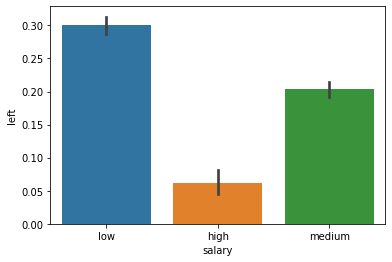

In [80]:
sns.barplot(x=X_train.salary, y=y_train)

Therefore it makes sense to use the label encoder with low, medium, and high salary being converted to 0, 1, and 2 respectively.

In [81]:
salary_encoder= {'low' : 0, 'medium' : 1, 'high' : 2}

X_train['salary']=X_train.salary.map(salary_encoder)
X_test['salary']=X_test.salary.map(salary_encoder)

In [82]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

dept_encoder = OneHotEncoder(handle_unknown='ignore')
dept_encoder.fit_transform(X_train[['Department']])
dept_encoder.transform(X_test[['Department']])


transformer = make_column_transformer(
    (OneHotEncoder(), ['Department']),
    remainder='passthrough')

transformed = transformer.fit_transform(X_train)
X_train = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names()
)

transformed = transformer.transform(X_test)
X_test = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names()
)

In [83]:
X=X_train.copy()
X['left']=y_train

# Data Analysis

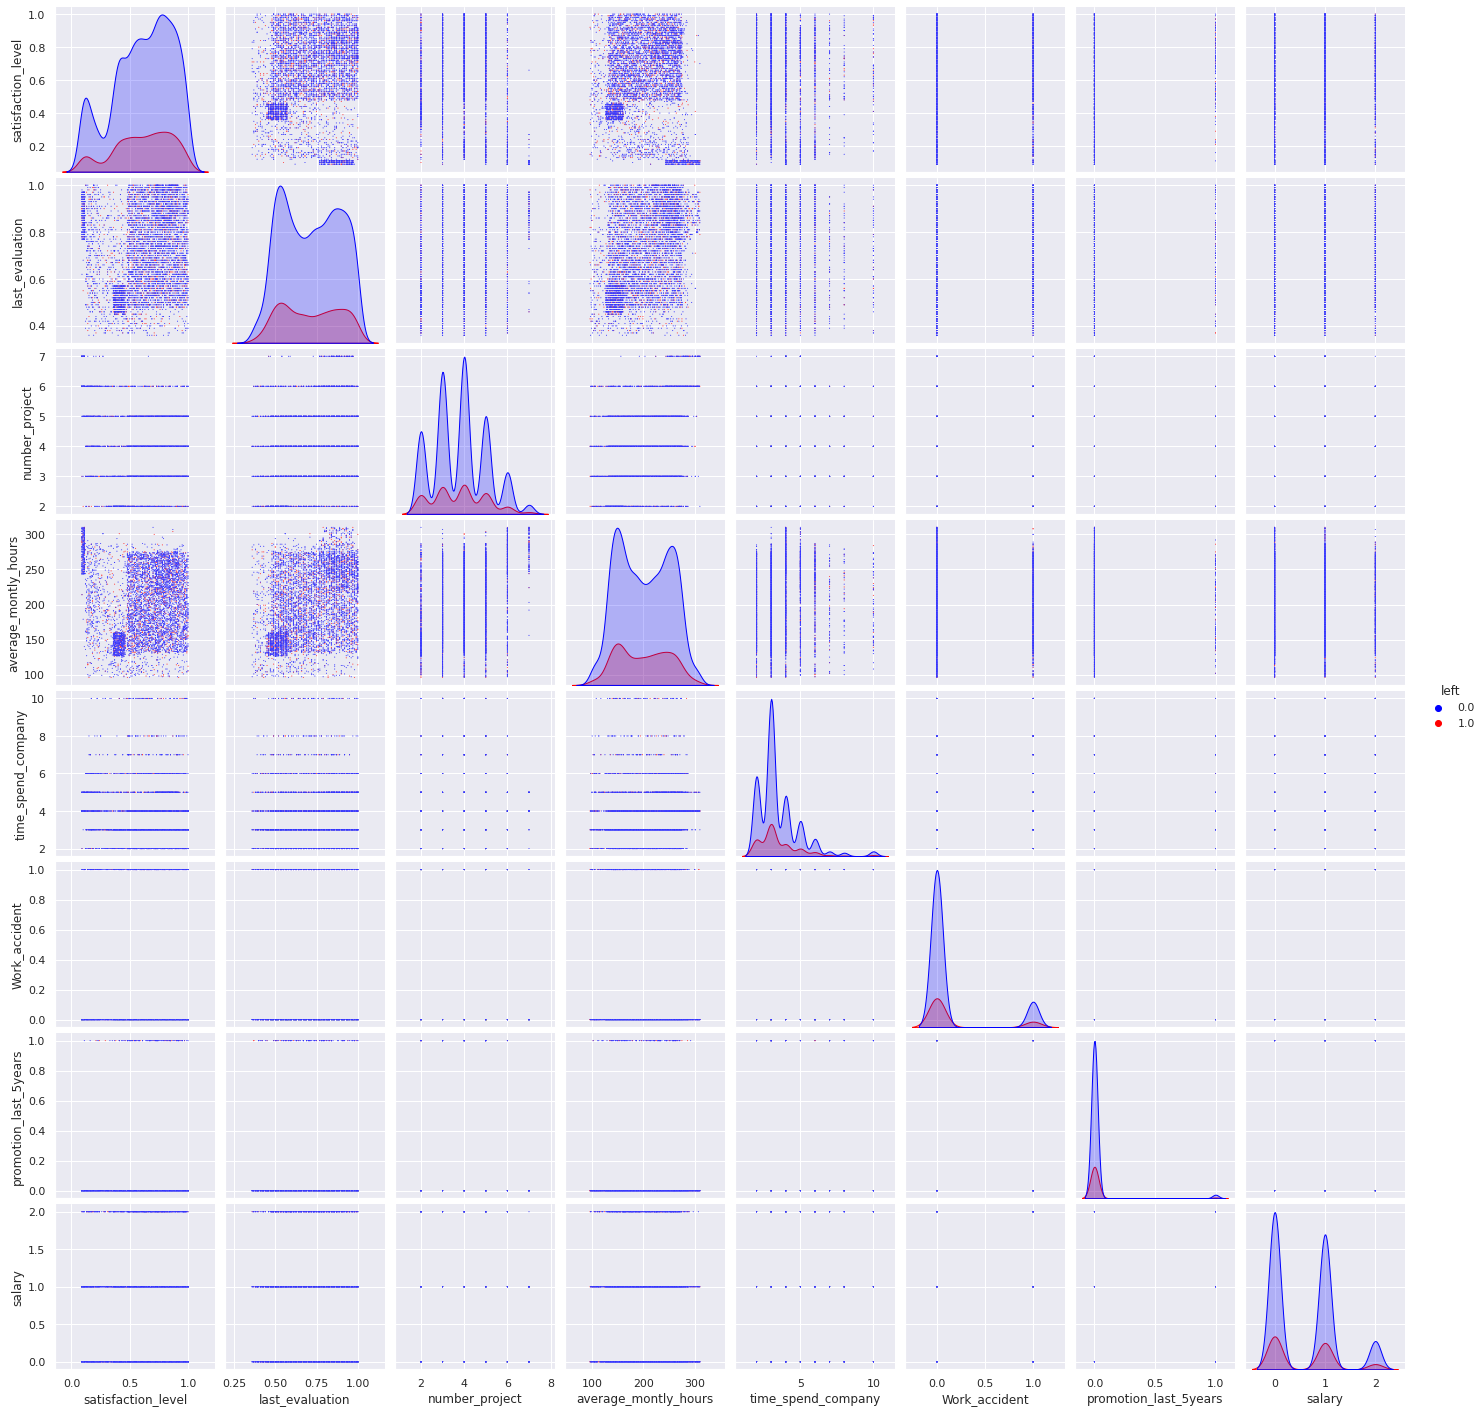

In [103]:
sns.set(rc = {'figure.figsize':(10,10)})
sns.pairplot(data=X, vars=[feat for feat in X.columns if not (('left'== feat) or ('one' in feat))], hue='left', palette=['blue','red'], plot_kws={"s": 1})

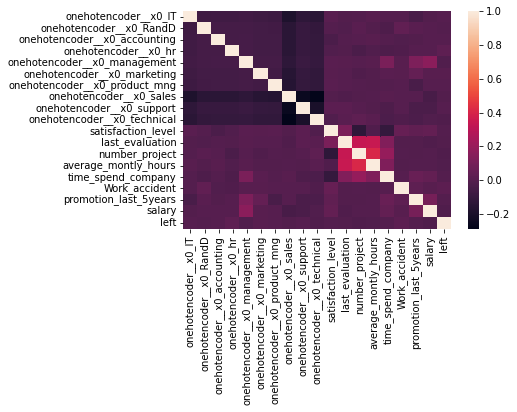

In [85]:
sns.heatmap(X.corr(), 
        xticklabels=X.columns,
        yticklabels=X.columns)


The features with highest correlations are 'last_evaluation', 'number_project', 'average_montly_hours', and 'time_spend_company'.

We see from the correlation heatmap that the correlation of the target with all the features is low. Moreover, the pairwise distributions indicate that the linear model might not perform well.

# Linear Regreesion Model



In [104]:
from sklearn.linear_model import RidgeClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import random

numeric_transformer = Pipeline(
    steps=[('scaler', StandardScaler())]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore")



preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), X_train.columns)
    ]
)

model = Pipeline(
    steps=[("preprocessor", preprocessor), 
            ("model", RidgeClassifierCV(alphas=[ random.uniform(0.1,1)* 10**x for x in range(-3,2) for _ in range(20)], cv=5))
           ]
)

In [105]:
model.fit(X_train,y=y_train)
model['model'].best_score_

0.7745772386193096

**Feature engineering**

Since the accuracy of the best model is only about 0.77, we need to build a stronger model. One idea is to introduce polynomial features. 

We decided to add polynomial features for the float type features, and squares of the features 'number_project' and 'time_spend_company'.

The first was motivated by the joint plots and the features having float values.

The second decision was also based on the joint plots above, these features have employees who left concentrated around minimal and maximal values.

In [89]:
from sklearn.preprocessing import PolynomialFeatures

#The preprocessor will rescale columns and add polynomial features
preprocessor = ColumnTransformer(
    transformers=[
        ("poly", PolynomialFeatures(8), ['satisfaction_level', 'last_evaluation','average_montly_hours'] ),
        ("poly2", PolynomialFeatures(2), ['number_project','time_spend_company']),
        ('scaler', StandardScaler(), X_train.columns)
    ]
)


model = Pipeline(
    steps=[("preprocessor", preprocessor), 
            ("model", RidgeClassifierCV(alphas=[ random.uniform(0.1,1)* 10**x for x in range(-3,2) for _ in range(10)], cv=5))
           ]
)

In [90]:
model.fit(X_train,y=y_train)
model['model'].best_score_

0.9446942471235618

Finally, it is time to test the model on the unused test data:

In [91]:
print('Accuracy on test data:', model.score(X_test,y_test))

Accuracy on test data: 0.9486


# XGBoost model

Next we use the XGBClassifier model provided in sklearn package. To tune the hyperparameters we perform grid search with cross validation (GridSearchCV) trying different combinations until we see no significant change in the validation score.

There was no need to add new features here, the XGB tree based model has enough complexity not to underfit the training data.

In [92]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV




#The model consists of the scaler and XGBClassifier
clf = Pipeline(
    steps=[('scaler', StandardScaler()),
            ("xgb", XGBClassifier(cv=5))
           ]
)


#To tune the parameters, experiment with different combinations of values here.
#They are currently set to the values that give best validation score that we could find.
param_grid = {
    "xgb__n_estimators": [300],
    "xgb__learning_rate": [0.3],
    "xgb__eta":[0.1],
    "xgb__max_depth": [1],
    "xgb__objective":['reg:squarederror'],
    'xgb__min_child_weight': [4],
    'xgb__subsample': [0.7],
    'xgb__reg_lambda':[0.55]
}

search = GridSearchCV(clf, param_grid=param_grid, cv = 5, scoring='accuracy',n_jobs=-1)


#Fit the model and print the parameters of the best model found in the Grid search.
search.fit(X_train,y_train)
print(search.best_params_)

{'xgb__eta': 0.1, 'xgb__learning_rate': 0.3, 'xgb__max_depth': 1, 'xgb__min_child_weight': 4, 'xgb__n_estimators': 300, 'xgb__objective': 'reg:squarederror', 'xgb__reg_lambda': 0.55, 'xgb__subsample': 0.7}


In [93]:
#Best validation score
search.best_score_

0.9482947473736869

Test the model:

In [94]:
search.score(X_test,y_test)

0.9498

The XGBClassifier with 95% accuracy performs slightly better than the linear regression model. 